In [27]:
import json
import requests
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
import pandas as pd
import seaborn as sns 
import itertools
import time
from oaipmh.client import Client
from oaipmh.metadata import MetadataRegistry, oai_dc_reader
import random
pd.set_option('display.max_colwidth', None)

In [28]:
fuji_service = 'http://localhost:1071/fuji/api/v1/evaluate'
data_dir = 'results'

Request metric defs

In [29]:
metrics = []
try:
    request = requests.get('http://localhost:1071/fuji/api/v1/metrics',headers={'Content-Type': 'application/json'}, auth=('username', 'password'))
    mm = request.json()['metrics']
    for m in mm:
        metrics.append({k: m[k] for k in ('metric_identifier', 'metric_name', 'total_score')})
except requests.exceptions.RequestException as e:
    print(e)
except requests.exceptions.ConnectionError as e1:
    print(e1)

In [30]:
df_metrics = pd.DataFrame.from_dict(metrics)
df_metrics

,metric_identifier,metric_name,total_score
0,FsF-F1-01D,Data is assigned a globally unique identifier.,1
1,FsF-F1-02D,Data is assigned a persistent identifier.,1
2,FsF-F2-01M,"Metadata includes descriptive core elements (creator, title, data identifier, publisher, publication date, summary and keywords) to support data findability.",2
3,FsF-F3-01M,Metadata includes the identifier of the data it describes.,1
4,FsF-F4-01M,Metadata is offered in such a way that it can be retrieved programmatically.,2
5,FsF-A1-01M,Metadata contains access level and access conditions of the data.,1
6,FsF-A1-02MD,Metadata as well as data are retrievable by their identifier using a standardized communications protocol.,2
7,FsF-A2-01M,"Metadata remains available, even if the data is no longer available.",1
8,FsF-I1-01M,Metadata is represented using a formal knowledge representation language.,2
9,FsF-I1-02M,Metadata uses semantic resources,1


Request phaidra italy records

In [31]:
datasets = []
max_dataset = 1500
oai_phaidra = 'https://fc.cab.unipd.it/oaiprovider/'
timestr = time.strftime("%Y%m%d")
timestr

'20201003'

In [32]:
oai_sets =[]
registry = MetadataRegistry()
registry.registerReader('oai_dc', oai_dc_reader)
client = Client(oai_phaidra, registry)
for s in client.listSets():
    oai_sets.append(s[0])

In [33]:
oai_sets

['fisica',
 'tavole-parietali-anonime',
 'zoologische-wandtafeln-leuckart',
 'zoologische-wandtafeln-leuckart-nitsche',
 'zoologische-wandtafeln-pfurtscheller',
 'collection-remy-perrier-cepede',
 'BELF',
 'PSMC']

In [34]:
dataset_all = []
datasets_wo_metadata = []

In [35]:
%%time
#https://fc.cab.unipd.it/oaiprovider/?verb=ListRecords&metadataPrefix=oai_dc
registry = MetadataRegistry()
registry.registerReader('oai_dc', oai_dc_reader)
client = Client(oai_phaidra, registry)
for record in client.listRecords(metadataPrefix='oai_dc'):
    localid =  record[0].identifier()
    if record[1]:
        metadata = record[1].getMap()
        identifier = None
        resource_type = None
        rights = None
        identifiers = [d for d in metadata['identifier'] if d.startswith('hdl:')]
        alt_identifiers = [d for d in metadata['identifier'] if d.startswith('http')]
        if identifiers:
            identifier = identifiers[0].replace('hdl:','https://hdl.handle.net/')
        else:
            identifier = alt_identifiers[0]
        data = {}
        data['id']= localid
        data['identifier'] = identifier
        data['type']= metadata.get('type')[0]
        data['rights']= metadata.get('rights')[0]
        dataset_all.append(data)
    else:
        datasets_wo_metadata.append(record[0].identifier())

Wall time: 12min 40s


In [36]:
len(dataset_all) #29896

415900

In [37]:
len(datasets_wo_metadata)

663

In [38]:
#group datasets by type
df = pd.DataFrame(dataset_all)
df.head()

,id,identifier,type,rights
0,oai:cab.unipd.it:o:100000,https://phaidra.cab.unipd.it/o:100000,Page,http://creativecommons.org/licenses/by-nc-nd/4.0/legalcode
1,oai:cab.unipd.it:o:100001,https://phaidra.cab.unipd.it/o:100001,Page,http://creativecommons.org/licenses/by-nc-nd/4.0/legalcode
2,oai:cab.unipd.it:o:100002,https://phaidra.cab.unipd.it/o:100002,Page,http://creativecommons.org/licenses/by-nc-nd/4.0/legalcode
3,oai:cab.unipd.it:o:100003,https://phaidra.cab.unipd.it/o:100003,Page,http://creativecommons.org/licenses/by-nc-nd/4.0/legalcode
4,oai:cab.unipd.it:o:100004,https://phaidra.cab.unipd.it/o:100004,Page,http://creativecommons.org/licenses/by-nc-nd/4.0/legalcode


In [39]:
df[df.identifier.isnull()].shape, df[df.id.isnull()].shape

((0, 4), (0, 4))

In [40]:
df.rights.unique()

array(['http://creativecommons.org/licenses/by-nc-nd/4.0/legalcode',
       'All rights reserved',
       'http://creativecommons.org/licenses/by-nc-sa/4.0/legalcode',
       'http://creativecommons.org/licenses/by-nc-sa/2.0/it/legalcode',
       'http://creativecommons.org/licenses/by-nc-nd/2.0/it/legalcode',
       'http://creativecommons.org/licenses/by-sa/4.0/legalcode',
       'http://creativecommons.org/licenses/by-nc/4.0/legalcode',
       'http://creativecommons.org/licenses/by-nc/2.0/it/legalcode',
       'http://creativecommons.org/licenses/by/4.0/legalcode',
       'http://creativecommons.org/licenses/by/2.0/it/legalcode'],
      dtype=object)

In [41]:
path_df =data_dir+'/'+'phaidraitaly_df_'+timestr+'.csv'
df.to_csv(path_df, index = False)

In [42]:
incomplete_file = data_dir+'/'+'phaidraitaly_incomplete_'+timestr+'.txt'
with open(incomplete_file, 'w') as f:
    for item in datasets_wo_metadata:
        f.write("%s\n" % item)

In [43]:
df.groupby('type')['id'].nunique()

type
Book             1966
Collection        921
Image           21051
MovingImage        44
PDFDocument      5021
Page           386889
Unknown             8
Name: id, dtype: int64

In [44]:
df_filter = df.loc[(df['type'] != 'Unknown') & (df['type'] != 'Page')]

In [45]:
df_filter.shape

(29003, 4)

In [46]:
df_filter = df_filter.sample(n = max_dataset)

In [47]:
df_filter.groupby('rights')['id'].nunique()

rights
All rights reserved                                              590
http://creativecommons.org/licenses/by-nc-nd/4.0/legalcode       102
http://creativecommons.org/licenses/by-nc-sa/2.0/it/legalcode      2
http://creativecommons.org/licenses/by-nc-sa/4.0/legalcode       618
http://creativecommons.org/licenses/by-nc/4.0/legalcode           32
http://creativecommons.org/licenses/by/4.0/legalcode             156
Name: id, dtype: int64

In [48]:
df_filter.groupby('type')['id'].nunique()

type
Book            110
Collection       52
Image          1051
MovingImage       4
PDFDocument     283
Name: id, dtype: int64

In [49]:
datasets = df_filter['identifier'].tolist()

In [50]:
len(datasets) #old 29894

1500

In [51]:
datalist_file = data_dir+'/'+'phaidraitaly_datasets_selected_'+timestr+'.txt'
with open(datalist_file, 'w') as f:
    for item in datasets:
        f.write("%s\n" % item)

In [52]:
datasets[:5]

['https://hdl.handle.net/11168/11.10587',
 'https://hdl.handle.net/11168/11.432843',
 'https://hdl.handle.net/11168/11.355948',
 'https://hdl.handle.net/11168/11.419813',
 'https://hdl.handle.net/11168/11.1162']

In [53]:
%%time 
all_records = []
for d in datasets:
    req = {'object_identifier':d, 'test_debug':True, 'oaipmh_endpoint':oai_phaidra}
    r = requests.post(fuji_service, data=json.dumps(req), headers={'Content-Type': 'application/json'}, auth=('username', 'password'))
    json_data = r.json()
    records = {}
    records['identifier'] = d
    records['result'] = json_data.get('results')
    all_records.append(records)

Wall time: 2h 48min 34s


In [54]:
file_name = data_dir+'/'+'phaidraitaly_'+timestr+'.json'
with open(file_name, 'w') as f:
    json.dump(all_records, f)

In [55]:
#timestr ='20200908'
#file_name ='results/phaidraitaly_'+timestr+'.json'
with open(file_name) as json_file:
    data = json.load(json_file)

In [56]:
def get_assessment_result(id):
    jsn = None
    for data_dict in data:
        if data_dict['identifier'] == id:
            jsn = data_dict['result']
    return jsn

In [57]:
test_dataset ='https://hdl.handle.net/11168/11.436047'

In [58]:
get_assessment_result(test_dataset)

In [59]:
final = []
for data_dict in data:
    results = {}
    results['identifier'] = data_dict['identifier']
    dd = data_dict['result'] # list of dict
    #print(results['identifier'])
    for d in dd:
        metric_identifier = d['metric_identifier']
        sub_principle = metric_identifier.split('-')[1]
        principle = sub_principle[0]+'_earned'
        principle_total = sub_principle[0]+'_total'
        if not sub_principle in results:
            results[sub_principle] = d['score']['earned']
        else:
            results[sub_principle] += d['score']['earned']
        if not principle in results:
            results[principle] = d['score']['earned']
        else:
            results[principle] += d['score']['earned']
        if not principle_total in results:
            results[principle_total] = d['score']['total']
        else:
            results[principle_total] += d['score']['total']
    final.append(results)

In [60]:
df_results = pd.DataFrame.from_dict(final)

In [61]:
cols = ['identifier','F1','F2','F3','F4','A1','A1','I1','I3','R1','R1.1','R1.2','R1.3','F_earned','F_total','A_earned','A_total','I_earned','I_total','R_earned','R_total']
df_results = df_results[cols]

In [62]:
df_results.head()

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,R1.2,R1.3,F_earned,F_total,A_earned,A_total,I_earned,I_total,R_earned,R_total
0,https://hdl.handle.net/11168/11.10587,2,0,0,0,0,0,0,0,0,...,0,0,2,7,0,1,0,4,0,9
1,https://hdl.handle.net/11168/11.432843,2,0,0,0,0,0,0,0,0,...,0,0,2,7,0,1,0,4,0,9
2,https://hdl.handle.net/11168/11.355948,2,0,0,0,0,0,0,0,0,...,0,0,2,7,0,1,0,4,0,9
3,https://hdl.handle.net/11168/11.419813,2,0,0,0,0,0,0,0,0,...,0,0,2,7,0,1,0,4,0,9
4,https://hdl.handle.net/11168/11.1162,2,0,0,0,0,0,0,0,0,...,0,0,2,7,0,1,0,4,0,9


In [63]:
df_results.iloc[0]

identifier    https://hdl.handle.net/11168/11.10587
F1                                                2
F2                                                0
F3                                                0
F4                                                0
A1                                                0
A1                                                0
I1                                                0
I3                                                0
R1                                                0
R1.1                                              0
R1.2                                              0
R1.3                                              0
F_earned                                          2
F_total                                           7
A_earned                                          0
A_total                                           1
I_earned                                          0
I_total                                           4
R_earned    

In [64]:
df_results ['F_Principle'] = (df_results ['F_earned'] / df_results ['F_total'] ).round(2)
df_results ['A_Principle'] = (df_results ['A_earned'] / df_results ['A_total'] ).round(2)
df_results ['I_Principle'] = (df_results ['I_earned'] / df_results ['I_total'] ).round(2)
df_results ['R_Principle' ]= (df_results ['R_earned'] / df_results ['R_total']).round(2)

In [65]:
df_results.head()

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,A_earned,A_total,I_earned,I_total,R_earned,R_total,F_Principle,A_Principle,I_Principle,R_Principle
0,https://hdl.handle.net/11168/11.10587,2,0,0,0,0,0,0,0,0,...,0,1,0,4,0,9,0.29,0.0,0.0,0.0
1,https://hdl.handle.net/11168/11.432843,2,0,0,0,0,0,0,0,0,...,0,1,0,4,0,9,0.29,0.0,0.0,0.0
2,https://hdl.handle.net/11168/11.355948,2,0,0,0,0,0,0,0,0,...,0,1,0,4,0,9,0.29,0.0,0.0,0.0
3,https://hdl.handle.net/11168/11.419813,2,0,0,0,0,0,0,0,0,...,0,1,0,4,0,9,0.29,0.0,0.0,0.0
4,https://hdl.handle.net/11168/11.1162,2,0,0,0,0,0,0,0,0,...,0,1,0,4,0,9,0.29,0.0,0.0,0.0


In [66]:
df_hist = df_results[['identifier','F_Principle','A_Principle','I_Principle','R_Principle']]
df_hist

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://hdl.handle.net/11168/11.10587,0.29,0.0,0.0,0.0
1,https://hdl.handle.net/11168/11.432843,0.29,0.0,0.0,0.0
2,https://hdl.handle.net/11168/11.355948,0.29,0.0,0.0,0.0
3,https://hdl.handle.net/11168/11.419813,0.29,0.0,0.0,0.0
4,https://hdl.handle.net/11168/11.1162,0.29,0.0,0.0,0.0
...,...,...,...,...,...
1495,https://hdl.handle.net/11168/11.3916,0.29,0.0,0.0,0.0
1496,https://hdl.handle.net/11168/11.1154,0.29,0.0,0.0,0.0
1497,https://hdl.handle.net/11168/11.386122,0.29,0.0,0.0,0.0
1498,https://hdl.handle.net/11168/11.8378,0.29,0.0,0.0,0.0


In [67]:
df_hist[df_hist.F_Principle <50].iloc[0]

identifier     https://hdl.handle.net/11168/11.10587
F_Principle                                     0.29
A_Principle                                        0
I_Principle                                        0
R_Principle                                        0
Name: 0, dtype: object

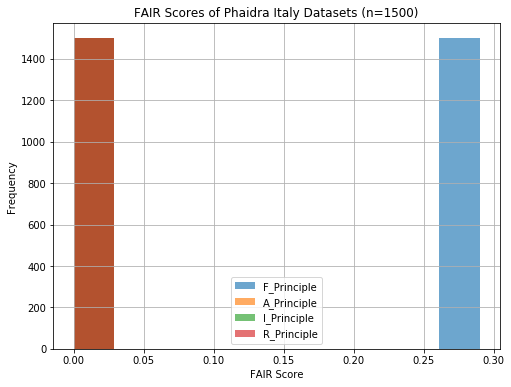

In [68]:
#timestr ='20200908'
title = "FAIR Scores of Phaidra Italy Datasets (n="+str(len(df_hist))+")"
df_hist.plot.hist(sharex=True,sharey=True,alpha=0.65,figsize = (8,6), title=title)
plt.xlabel('FAIR Score')
fig_name = data_dir+'/'+'phaidraitaly_'+timestr+'.png'
plt.savefig(fig_name)

In [69]:
def histograms_plot(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(8,6))
    # set palette 
    palette = itertools.cycle(sns.color_palette())
    for i, feature in enumerate(features):
        c = next(palette)
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].plot.hist(bins=20, ax=ax, color=c, range=(0, 1.0))
        ax.set_title("FAIR Score - "+feature+ ' (n=' + str(len(df_hist))+')')
        ax.set(xlabel="Score", ylabel="Frequency")
    fig.subplots_adjust(top=1.4)
    plt.show()
    fig_name = data_dir+'/'+'sub_phaidraitaly_'+timestr+'.png'
    plt.savefig(fig_name)

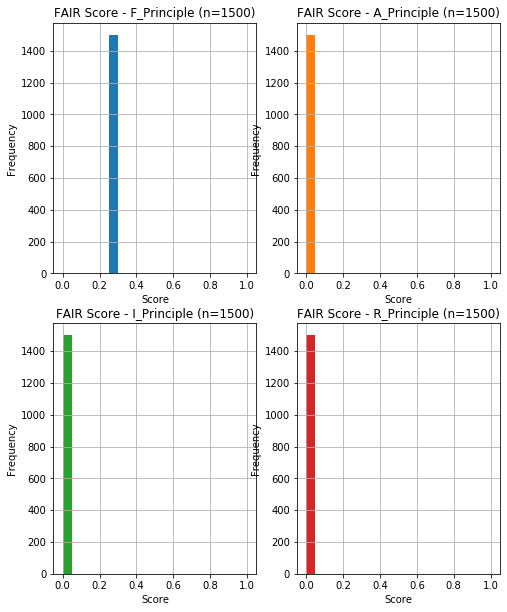

<Figure size 432x288 with 0 Axes>

In [70]:
histograms_plot(df_hist,df_hist.columns[1:],2,2)

Findability

In [71]:
df_hist[df_hist.F_Principle < 0.9]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://hdl.handle.net/11168/11.10587,0.29,0.0,0.0,0.0
1,https://hdl.handle.net/11168/11.432843,0.29,0.0,0.0,0.0
2,https://hdl.handle.net/11168/11.355948,0.29,0.0,0.0,0.0
3,https://hdl.handle.net/11168/11.419813,0.29,0.0,0.0,0.0
4,https://hdl.handle.net/11168/11.1162,0.29,0.0,0.0,0.0
...,...,...,...,...,...
1495,https://hdl.handle.net/11168/11.3916,0.29,0.0,0.0,0.0
1496,https://hdl.handle.net/11168/11.1154,0.29,0.0,0.0,0.0
1497,https://hdl.handle.net/11168/11.386122,0.29,0.0,0.0,0.0
1498,https://hdl.handle.net/11168/11.8378,0.29,0.0,0.0,0.0


In [72]:
df_hist[df_hist.F_Principle >= 0.9].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle


Accessibility

In [73]:
df_hist[df_hist.A_Principle < 0.6].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://hdl.handle.net/11168/11.10587,0.29,0.0,0.0,0.0
1,https://hdl.handle.net/11168/11.432843,0.29,0.0,0.0,0.0
2,https://hdl.handle.net/11168/11.355948,0.29,0.0,0.0,0.0
3,https://hdl.handle.net/11168/11.419813,0.29,0.0,0.0,0.0
4,https://hdl.handle.net/11168/11.1162,0.29,0.0,0.0,0.0


Interoperability

In [74]:
df_hist[df_hist.I_Principle < 0.6].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://hdl.handle.net/11168/11.10587,0.29,0.0,0.0,0.0
1,https://hdl.handle.net/11168/11.432843,0.29,0.0,0.0,0.0
2,https://hdl.handle.net/11168/11.355948,0.29,0.0,0.0,0.0
3,https://hdl.handle.net/11168/11.419813,0.29,0.0,0.0,0.0
4,https://hdl.handle.net/11168/11.1162,0.29,0.0,0.0,0.0


In [75]:
df_hist[df_hist.I_Principle > 0.6].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle


Reusability

In [76]:
df_hist[df_hist.R_Principle < 0.4].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://hdl.handle.net/11168/11.10587,0.29,0.0,0.0,0.0
1,https://hdl.handle.net/11168/11.432843,0.29,0.0,0.0,0.0
2,https://hdl.handle.net/11168/11.355948,0.29,0.0,0.0,0.0
3,https://hdl.handle.net/11168/11.419813,0.29,0.0,0.0,0.0
4,https://hdl.handle.net/11168/11.1162,0.29,0.0,0.0,0.0


In [77]:
df_hist[df_hist.R_Principle > 0.6].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle


In [78]:
df_hist[df_hist.R_Principle < 0.6]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://hdl.handle.net/11168/11.10587,0.29,0.0,0.0,0.0
1,https://hdl.handle.net/11168/11.432843,0.29,0.0,0.0,0.0
2,https://hdl.handle.net/11168/11.355948,0.29,0.0,0.0,0.0
3,https://hdl.handle.net/11168/11.419813,0.29,0.0,0.0,0.0
4,https://hdl.handle.net/11168/11.1162,0.29,0.0,0.0,0.0
...,...,...,...,...,...
1495,https://hdl.handle.net/11168/11.3916,0.29,0.0,0.0,0.0
1496,https://hdl.handle.net/11168/11.1154,0.29,0.0,0.0,0.0
1497,https://hdl.handle.net/11168/11.386122,0.29,0.0,0.0,0.0
1498,https://hdl.handle.net/11168/11.8378,0.29,0.0,0.0,0.0
